<a href="https://colab.research.google.com/github/SOUMEE2000/Machine-Learning-Stash/blob/main/Biomedical%20Image%20Segmentation/SA_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Main Model**

* This is an implementation of the Spatial-Attention U Net model whose paper can be found here [here](https://arxiv.org/ftp/arxiv/papers/2004/2004.03696.pdf). 
* The datset used here is DRIVE for retinal image segmentation.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

In [ ]:
#get access google drive data into google colab

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Datasets/DRIVE.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('finish')

finish


In [ ]:
# Spatial Attention part of the model.

from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, \
    Conv2D, Add, Activation, Lambda,Conv1D

def spatial_attention(input_feature):
    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [ ]:
!pip install keras-drop-block

## **Architecture**

**The main architecture is below**
* DropBlock has been used instead of plain dropout layers.
* https://www.youtube.com/watch?v=GcvGxXePI2g&t=320s explains the concept of Dropblock and how it is better than dropout layers.

*from keras_drop_block import DropBlock2D*

In [ ]:
from keras.optimizers import *
from keras.models import Model

from keras_drop_block import DropBlock2D

from keras.layers import Input,Conv2DTranspose, MaxPooling2D,BatchNormalization,concatenate,Activation, Conv2D

# The SA-UNet architecture
def SA_UNet(input_size=(512, 512, 3), block_size=7,keep_prob=0.9,start_neurons=16,lr=1e-3):

    inputs = Input(input_size)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv1)
    conv1= BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(conv1)
    conv1 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)



    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(conv2)
    conv2 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)


    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(conv3)
    conv3 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)


    convm = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    convm = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(convm)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)
    convm = spatial_attention(convm)
    convm = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(convm)
    convm = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(convm)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Activation('relu')(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Activation('relu')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Activation('relu')(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Activation('relu')(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])


    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Activation('relu')(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = DropBlock2D(block_size=block_size, keep_prob=keep_prob)(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Activation('relu')(uconv1)
    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)

    model = Model(inputs, output_layer)

    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

    return model


## **Data Augmentation**

* The DRIVE Dataset has only 20 training samples, so Data augmentation has been used.
* The original image have been rotated 3 times and gaussian noise has been introduced. So for each of the 20 training images we have 4 noisy and 3 rotated so 7 additional images. 

In [ ]:
# Function for generating random Gaussian noise

def noisy(img, noise_type="gauss"):
    '''
    ### Adding Noise ###
    img: image
    cj_type: {gauss: gaussian, sp: salt & pepper}
    '''
    if noise_type == "gauss":
        image=img.copy() 
        mean=0
        st=0.7
        gauss = np.random.normal(mean,st,image.shape)
        gauss = gauss.astype('uint8')
        image = cv2.add(image,gauss)
        return image
    
    elif noise_type == "sp":
        image=img.copy() 
        prob = 0.05
        if len(image.shape) == 2:
            black = 0
            white = 255            
        else:
            colorspace = image.shape[2]
            if colorspace == 3:  # RGB
                black = np.array([0, 0, 0], dtype='uint8')
                white = np.array([255, 255, 255], dtype='uint8')
            else:  # RGBA
                black = np.array([0, 0, 0, 255], dtype='uint8')
                white = np.array([255, 255, 255, 255], dtype='uint8')
        probs = np.random.random(image.shape[:2])
        image[probs < (prob / 2)] = black
        image[probs > 1 - (prob / 2)] = white
        return image

In [ ]:
import os

import cv2
from keras.callbacks import TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import keras.backend as K
#import  scipy.misc.pilutil
data_location = ''

training_images_loc = data_location + '/content/DRIVE/training/images/'
training_label_loc = data_location + '/content/DRIVE/training/1st_manual/'

train_files = os.listdir(training_images_loc)
train_data = []
train_label = []
desired_size = 512
for i in train_files:
    im = plt.imread(training_images_loc + i)
    label = plt.imread(training_label_loc + i.split('_')[0] + '_manual1.gif')
    train_data.append(cv2.resize(im, (desired_size, desired_size)))
    temp = cv2.resize(label, (desired_size, desired_size))
    train_label.append(temp)

    # adding gaussian noise
    noisy_im=noisy(im)
    train_data.append(cv2.resize(noisy_im, (desired_size, desired_size)))
    temp = cv2.resize(label, (desired_size, desired_size))
    train_label.append(temp)

    # original image rotated by 90
    rotated_img = cv2.rotate(im, cv2.cv2.ROTATE_90_CLOCKWISE)
    rotated_label= cv2.cv2.rotate(label, cv2.cv2.ROTATE_90_CLOCKWISE)
    train_data.append(cv2.resize(rotated_img, (desired_size, desired_size)))
    temp = cv2.resize(rotated_label, (desired_size, desired_size))
    train_label.append(temp)

    # adding gaussian noise
    noisy_im=noisy(rotated_img)
    train_data.append(cv2.resize(rotated_img, (desired_size, desired_size)))
    temp = cv2.resize(rotated_label, (desired_size, desired_size))
    train_label.append(temp)

    # original image rotated by 180
    rotated_img = cv2.rotate(rotated_img, cv2.cv2.ROTATE_90_CLOCKWISE)
    rotated_label= cv2.cv2.rotate(rotated_label, cv2.cv2.ROTATE_90_CLOCKWISE)
    train_data.append(cv2.resize(rotated_img, (desired_size, desired_size)))
    temp = cv2.resize(rotated_label, (desired_size, desired_size))
    train_label.append(temp)

    # adding gaussian noise
    noisy_im=noisy(rotated_img)
    train_data.append(cv2.resize(rotated_img, (desired_size, desired_size)))
    temp = cv2.resize(rotated_label, (desired_size, desired_size))
    train_label.append(temp)
    
    # original image rotated by 270
    rotated_img = cv2.rotate(rotated_img, cv2.cv2.ROTATE_90_CLOCKWISE)
    rotated_label= cv2.cv2.rotate(rotated_label, cv2.cv2.ROTATE_90_CLOCKWISE)
    train_data.append(cv2.resize(rotated_img, (desired_size, desired_size)))
    temp = cv2.resize(rotated_label, (desired_size, desired_size))
    train_label.append(temp)
    
    # adding gaussian noise
    noisy_im=noisy(rotated_img)
    train_data.append(cv2.resize(rotated_img, (desired_size, desired_size)))
    temp = cv2.resize(rotated_label, (desired_size, desired_size))
    train_label.append(temp)

train_data = np.array(train_data)
train_label = np.array(train_label)

x_train = train_data.astype('float32') / 255.
y_train = train_label.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), desired_size, desired_size, 3))  # adapt this if using `channels_first` image data format
y_train = np.reshape(y_train, (len(y_train), desired_size, desired_size, 1))  # adapt this if using `channels_first` im

TensorBoard(log_dir='./autoencoder', histogram_freq=0,
            write_graph=True, write_images=True)

model=SA_UNet(input_size=(desired_size,desired_size,3),start_neurons=16,lr=1e-3,keep_prob=0.82,block_size=7)
model.summary()

history=model.fit(x_train, y_train,
                epochs=100, #first  100 with lr=1e-3,,and last 50 with lr=1e-4
                batch_size=4,
                validation_split=0.1,
                shuffle=True,
                callbacks= [TensorBoard(log_dir='./autoencoder')])

print(history.history.keys())


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 512, 512, 16) 448         input_6[0][0]                    
__________________________________________________________________________________________________
drop_block2d_70 (DropBlock2D)   (None, 512, 512, 16) 524288      conv2d_80[0][0]                  
__________________________________________________________________________________________________
batch_normalization_70 (BatchNo (None, 512, 512, 16) 64          drop_block2d_70[0][0]            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:6068: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  warnings.warn('`tf.keras.backend.random_binomial` is deprecated, '


36/36 [==============================] - 21s 378ms/step - loss: 0.6124 - accuracy: 0.6628 - val_loss: 0.8760 - val_accuracy: 0.2645
Epoch 2/100
36/36 [==============================] - 12s 340ms/step - loss: 0.3680 - accuracy: 0.8747 - val_loss: 0.4131 - val_accuracy: 0.8763
Epoch 3/100
36/36 [==============================] - 12s 343ms/step - loss: 0.3198 - accuracy: 0.8801 - val_loss: 0.3441 - val_accuracy: 0.8763
Epoch 4/100
36/36 [==============================] - 12s 345ms/step - loss: 0.2897 - accuracy: 0.8791 - val_loss: 0.3202 - val_accuracy: 0.8763
Epoch 5/100
36/36 [==============================] - 12s 346ms/step - loss: 0.2550 - accuracy: 0.8856 - val_loss: 0.4753 - val_accuracy: 0.8879
Epoch 6/100
36/36 [==============================] - 12s 347ms/step - loss: 0.2207 - accuracy: 0.8967 - val_loss: 0.5350 - val_accuracy: 0.6681
Epoch 7/100
36/36 [==============================] - 13s 349ms/step - loss: 0.1939 - accuracy: 0.9033 - val_loss: 0.3279 - val_accuracy: 0.8756
Epoc

## **Accuracy and Predictions**

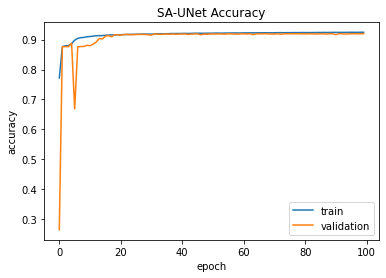

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('SA-UNet Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='lower right')
plt.show()

In [ ]:
test_images_loc='/content/DRIVE/test/test/images'

test_files= os.listdir(test_images_loc)
test_data=[]
for i in test_files:
  test_im= plt.imread('/content/DRIVE/test/test/images/' + i)
  test_data.append(cv2.resize(test_im,(desired_size, desired_size)))

test_data= np.array(test_data)
x_test = test_data.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), desired_size, desired_size, 3))  # adapt this if using `channels_first` image data format
y_pred= model.predict(x_test)

In [ ]:
y_pred.shape

(20, 512, 512, 1)

In [ ]:
y_pred[0]

array([[[3.1532396e-02],
        [3.3060403e-03],
        [2.6010901e-03],
        ...,
        [3.2056193e-03],
        [5.1252046e-03],
        [4.1445550e-02]],

       [[4.2147515e-03],
        [1.0464581e-04],
        [6.9977657e-05],
        ...,
        [1.1210297e-04],
        [1.7892676e-04],
        [4.8566246e-03]],

       [[2.8159223e-03],
        [5.8175705e-05],
        [4.3011587e-05],
        ...,
        [7.1207243e-05],
        [1.2208374e-04],
        [3.2822245e-03]],

       ...,

       [[3.3064852e-03],
        [9.2687405e-05],
        [4.6982892e-05],
        ...,
        [5.8624573e-05],
        [9.5218311e-05],
        [3.0845364e-03]],

       [[4.5525422e-03],
        [1.4620778e-04],
        [7.5904543e-05],
        ...,
        [1.0326477e-04],
        [1.9178483e-04],
        [5.2342340e-03]],

       [[2.8397495e-02],
        [3.8622003e-03],
        [2.3846638e-03],
        ...,
        [3.2225947e-03],
        [4.5814798e-03],
        [5.6083947e-02]]

In [ ]:
f= open("ground_truths.doc", "a+")

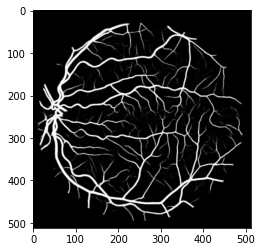

In [ ]:
# Converting array back to image

from PIL import Image 
i=1
for img in y_pred:
  #arr= np.array(img)
  img= np.reshape(img, (512,512))
  #img= Image.fromarray(arr)
  plt.imshow(img, cmap="gray")
  path="/content/results1/test_"+ str(i) + ".jpg"
  cv2.imwrite(str(path),img*255)                    # img*255 is important for cv2 to save the image properly.
  i= i+1

##  **Little checks**

In [ ]:
import os
import cv2
from keras.callbacks import TensorBoard,  ModelCheckpoint
import numpy as np
import keras.backend as K

In [ ]:
training_loc= "/content/DRIVE/training/images"
training_label_loc= "/content/DRIVE/training/1st_manual"

train_files= os.listdir(training_loc)

In [ ]:
train_files

['29_training.tif',
 '28_training.tif',
 '37_training.tif',
 '30_training.tif',
 '21_training.tif',
 '36_training.tif',
 '22_training.tif',
 '40_training.tif',
 '35_training.tif',
 '24_training.tif',
 '33_training.tif',
 '39_training.tif',
 '23_training.tif',
 '32_training.tif',
 '31_training.tif',
 '25_training.tif',
 '34_training.tif',
 '26_training.tif',
 '38_training.tif',
 '27_training.tif']

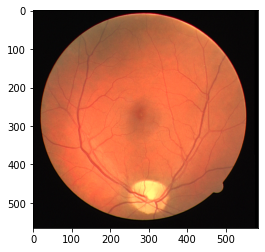

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
train_data=[]
train_label=[]
desired_size= 512

for i in train_files:
  im=plt.imread(training_loc + "/" + i)
  label = plt.imread(training_label_loc + "/" + i.split('_')[0] + '_manual1.gif')
  h_flip = cv2.rotate(im, cv2.cv2.ROTATE_90_CLOCKWISE)
  plt.imshow(h_flip)

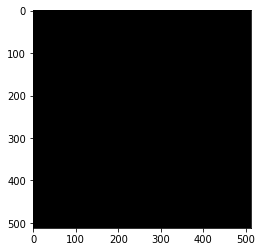

In [ ]:
img=y_pred[1]
arr= np.array(img)
arr= np.reshape(arr, (512,512))
img= Image.fromarray(arr)
plt.imshow(img, cmap="gray")

In [ ]:
# original image rotated by 90
    rotated_img = cv2.rotate(im, cv2.cv2.ROTATE_90_CLOCKWISE)
    rotated_label= cv2.cv2.rotate(label, cv2.cv2.ROTATE_90_CLOCKWISE)
    train_data.append(cv2.resize(rotated_img, (desired_size, desired_size)))
    temp = cv2.resize(rotated_label, (desired_size, desired_size))
    train_label.append(temp)

    # original image rotated by 180
    rotated_img = cv2.rotate(rotated_img, cv2.cv2.ROTATE_90_CLOCKWISE)
    rotated_label= cv2.cv2.rotate(rotated_label, cv2.cv2.ROTATE_90_CLOCKWISE)
    train_data.append(cv2.resize(rotated_img, (desired_size, desired_size)))
    temp = cv2.resize(rotated_label, (desired_size, desired_size))
    train_label.append(temp)
    
    # original image rotated by 270
    rotated_img = cv2.rotate(rotated_img, cv2.cv2.ROTATE_90_CLOCKWISE)
    rotated_label= cv2.cv2.rotate(rotated_label, cv2.cv2.ROTATE_90_CLOCKWISE)
    train_data.append(cv2.resize(rotated_img, (desired_size, desired_size)))
    temp = cv2.resize(rotated_label, (desired_size, desired_size))
    train_label.append(temp)